In [ ]:
pip install joblib

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
import logging
from datetime import datetime

In [16]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Loading the data

In [5]:
# Load data
climate1 = pd.read_csv("/content/drive/MyDrive/climate_data.csv")
climate2 = pd.read_csv("/content/drive/MyDrive/FarmWise/climate_data2.csv")
soil = pd.read_csv("/content/drive/MyDrive/FarmWise/soil_data.csv")


In [6]:
# Round to 2 or 3 decimals for consistency
climate1["Region"] = climate1["Region"].round(2)
climate2["Region"] = climate2["Region"].round(2)
soil["Region"] = soil["Region"].round(2)

# Check again if values align
#print(climate1['Region'].unique())
#print(climate2['Region'].unique())
#print(soil['Region'].unique())
print("climate1:", climate1['Region'].nunique(), climate1['Region'].value_counts().head())
print("climate2:", climate2['Region'].nunique(), climate2['Region'].value_counts().head())
print("soil:", soil['Region'].nunique(), soil['Region'].value_counts().head())



climate1: 5 Region
-0.69    8350
 0.74    8329
 0.03    8309
-1.41    8150
 1.46    7419
Name: count, dtype: int64
climate2: 5 Region
-0.71    12535
-1.41    12535
 0.71    12535
 0.00    12535
 1.41    12533
Name: count, dtype: int64
soil: 5 Region
-0.71    90
-1.41    90
 0.71    90
 1.41    90
 0.00    90
Name: count, dtype: int64


### Merging climare data 2 and soil data on region

In [7]:
# Merge only these two
df = pd.merge(soil, climate2, on="Region")  # If time info aligns, you can use DOY/YEAR too



In [8]:
# Prepare data
X = df.drop(columns=["GWETTOP", "GWETROOT", "GWETPROF", "Region"])
y = df["GWETTOP"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Generating synthetic data

In [9]:


# Feature names from your model
features =  ['YEAR_x', 'DOY', 'YEAR_y', 'MO', 'DY', 'T2M', 'T2MWET', 'T2M_RANGE', 'QV2M', 'PRECTOTCORR', 'PS', 'WS10M', 'WS10M_RANGE', 'WD10M', 'WD50M']

# Generate 5 samples of synthetic data
np.random.seed(42)
sample_data = pd.DataFrame(np.random.normal(loc=0, scale=1, size=(1, len(features))), columns=features)

# Show the fake test inputs
sample_data

,YEAR_x,DOY,YEAR_y,MO,DY,T2M,T2MWET,T2M_RANGE,QV2M,PRECTOTCORR,PS,WS10M,WS10M_RANGE,WD10M,WD50M
0,0.496714,-0.138264,0.647689,1.52303,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.54256,-0.463418,-0.46573,0.241962,-1.91328,-1.724918


### Encapsulating the model into an agent and testing it out with sample data

In [10]:
import os
import pandas as pd
import joblib
import logging
from datetime import datetime

class IrrigationAgent:
    def __init__(self, model_path, log_file='/content/drive/MyDrive/FarmWise/irrigation_schedule.log'):
        # Ensure the directory for the log file exists
        log_directory = os.path.dirname(log_file)  # Get the directory of the log file
        if not os.path.exists(log_directory):
            os.makedirs(log_directory)  # Create the directory if it doesn't exist

        # Load the pre-trained model
        self.model = joblib.load(model_path)

        # Set up logging explicitly to ensure it's writing to the log file
        logging.basicConfig(
            filename=log_file,
            level=logging.INFO,  # Log INFO and above levels
            format='%(asctime)s - %(levelname)s - %(message)s',
            force=True  # Force reconfiguration to ensure logging settings are correct
          )

    def log_irrigation_action(self, gwet_pred, status):
        """
        Log the irrigation action (whether to irrigate, wait, or conditions good)
        """
        print(f"Logging: Prediction = {gwet_pred}, Status = {status}")  # This will print to console to verify
        logging.info(f"Prediction: {gwet_pred}, Recommendation: {status}")


    def run(self, input_data):
        # If input is a dictionary, convert it to a DataFrame with one row
        if isinstance(input_data, dict):
            input_data = pd.DataFrame([input_data])

        # If input is a DataFrame, we can directly use it (no need to reshape)
        if isinstance(input_data, pd.DataFrame):
            input_array = input_data.values  # Convert to NumPy array (this is what the model expects)
        else:
            raise ValueError("Input must be a DataFrame or a dictionary")

        # Check the shape of the input data
        print(f"Input data shape: {input_array.shape}")  # This should be (1, n_features) for one sample

        # Make prediction using the trained model (only one sample or multiple samples)
        gwet_pred = self.model.predict(input_array)[0]  # Get prediction for the first sample

        # Decision logic based on the prediction
        if gwet_pred < 0.2:
            status = "💧 Irrigate Now"
        elif gwet_pred < 0.35:
            status = "🕒 Wait"
        else:
            status = "✅ Conditions Good"

        # Log the irrigation action
        self.log_irrigation_action(gwet_pred, status)

        # Return the result in a DataFrame for easy processing
        result_df = pd.DataFrame([[gwet_pred, status]], columns=["predicted_gwet_top", "recommendation"])
        return result_df


In [4]:
agent = IrrigationAgent(model_path='/content/drive/MyDrive/FarmWise/irrigation_model.pkl',log_file="/content/drive/MyDrive/FarmWise/irrigation_schedule.log")


In [11]:
# Sample input data (one sample as a dictionary)
input_data = {
    'YEAR_x': 0.496714,
    'DOY': -0.138264,
    'YEAR_y': 0.647689,
    'MO': 1.523030,
    'DY': -0.234153,
    'T2M': -0.234137,
    'T2MWET': 1.579213,
    'T2M_RANGE': 0.767435,
    'QV2M': -0.469474,
    'PRECTOTCORR': 0.542560,
    'PS': -0.463418,
    'WS10M': -0.465730,
    'WS10M_RANGE': 0.241962,
    'WD10M': -1.913280,
    'WD50M': -1.724918
}



# Get the result
result = agent.run(input_data)

# Print the results (DataFrame)
print(result)

# Check the contents of the log file (for debugging purposes)
with open('/content/drive/MyDrive/FarmWise/irrigation_schedule.log', 'r') as log_file:
    log_contents = log_file.readlines()
    print("Log contents:")
    print("".join(log_contents))


Input data shape: (1, 15)
Logging: Prediction = 0.747784707464493, Status = ✅ Conditions Good
   predicted_gwet_top     recommendation
0            0.747785  ✅ Conditions Good
Log contents:
2025-04-15 20:42:20,999 - INFO - Prediction: 0.747784707464493, Recommendation: ✅ Conditions Good



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [12]:
print("Type of result:", type(result))
print("Result contents:", result)


Type of result: <class 'pandas.core.frame.DataFrame'>
Result contents:    predicted_gwet_top     recommendation
0            0.747785  ✅ Conditions Good


In [ ]:
sample_data

,YEAR_x,DOY,YEAR_y,MO,DY,T2M,T2MWET,T2M_RANGE,QV2M,PRECTOTCORR,PS,WS10M,WS10M_RANGE,WD10M,WD50M
0,0.496714,-0.138264,0.647689,1.52303,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.54256,-0.463418,-0.46573,0.241962,-1.91328,-1.724918


In [13]:
import os

log_file_path = "/content/drive/MyDrive/FarmWise/irrigation_schedule.log"

# Check if the file exists
if os.path.exists(log_file_path):
    print(f"Log file found at: {log_file_path}")
else:
    print("Log file not found.")


Log file found at: /content/drive/MyDrive/FarmWise/irrigation_schedule.log


In [ ]:
import gc

# Run garbage collection to release memory
gc.collect()


53

In [14]:
# Check the contents of the log file after running the agent
log_file_path = '/content/drive/MyDrive/FarmWise/irrigation_schedule.log'

# Print the contents of the log file
with open(log_file_path, 'r') as file:
    log_contents = file.readlines()
    print("Log contents:")
    print("".join(log_contents))


Log contents:
2025-04-15 20:42:20,999 - INFO - Prediction: 0.747784707464493, Recommendation: ✅ Conditions Good



# Improving water estimation

In [17]:
import pandas as pd

# Load the fertilizer prediction dataset
file_path = '/content/drive/MyDrive/FarmWise/Fertilizer Prediction.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,32,51,41,Red,Ground Nuts,7,3,19,14-35-14
1,35,58,35,Black,Cotton,4,14,16,Urea
2,27,55,43,Sandy,Sugarcane,28,0,17,20-20
3,33,56,56,Loamy,Ground Nuts,37,5,24,28-28
4,32,70,60,Red,Ground Nuts,4,6,9,14-35-14


In [18]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns for standardization
numerical_cols = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

# Initialize the scaler
scaler = StandardScaler()

# Apply standardization to numerical columns
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Verify the result
data.head()


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0.123560,-1.501319,-0.338167,Red,Ground Nuts,-1.421396,-1.121987,-0.162494,14-35-14
1,0.869843,-0.448902,-0.844981,Black,Cotton,-1.688128,0.784910,-0.404603,Urea
2,-1.120246,-0.899938,-0.169229,Sandy,Sugarcane,0.445730,-1.642049,-0.323900,20-20
3,0.372321,-0.749593,0.928869,Loamy,Ground Nuts,1.245927,-0.775278,0.241021,28-28
4,0.123560,1.355240,1.266746,Red,Ground Nuts,-1.688128,-0.601924,-0.969523,14-35-14


## Formula for Water Requirement:
Water need can be calculated based on:

Moisture Deficit: If moisture is low, irrigation is needed.

Temperature: Higher temperatures require more water due to evaporation.

Humidity: High humidity can reduce the need for irrigation.

Water Needed (liters) = (Ideal Moisture - Current Moisture) * Area * Factor


In [19]:
def calculate_water_need(row, ideal_moisture=0.5):
    moisture_deficit = ideal_moisture - row['Moisture']  # Calculate moisture deficit

    # Adjust for temperature (warmer temperature means higher water need)
    temp_factor = 1 + (row['Temparature'] - 25) * 0.02  # +2% for each degree above 25°C

    # Adjust for humidity (higher humidity reduces water need)
    humidity_factor = 1 - (row['Humidity'] - 50) * 0.01  # -1% for each percent below 50%

    # Calculate the water needed in liters (assuming 1 hectare = 10,000m²)
    water_needed = moisture_deficit * 10000 * temp_factor * humidity_factor
    return water_needed


In [20]:
# Apply the water need calculation function to the dataset
data['WaterNeedLiters'] = data.apply(calculate_water_need, axis=1)

# Display the updated dataset with water need estimation
data[['Temparature', 'Humidity', 'Moisture', 'WaterNeedLiters']].head()


,Temparature,Humidity,Moisture,WaterNeedLiters
0,0.123560,-1.501319,-0.338167,6380.549710
1,0.869843,-0.448902,-0.844981,10469.576140
2,-1.120246,-0.899938,-0.169229,4823.069244
3,0.372321,-0.749593,0.928869,-3280.736654
4,0.123560,1.355240,1.266746,-5726.801537


In [21]:
from sklearn.model_selection import train_test_split

# Select features (independent variables) and target (dependent variable)
features = ['Temparature', 'Humidity', 'Moisture']  # Input features
target = 'WaterNeedLiters'  # Output target

# Extract features (X) and target (y)
X = data[features]
y = data[target]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
X_train

,Temparature,Humidity,Moisture
75220,0.621082,1.355240,1.435684
48955,-1.617768,0.302824,0.084179
44966,1.367365,1.505585,-1.351796
13568,-0.125201,0.302824,-1.098389
92727,-0.373963,1.505585,0.337586
...,...,...,...
6265,1.367365,1.204895,-1.013920
54886,-0.373963,-0.448902,1.520153
76820,1.118604,0.904205,-0.676043
860,-0.373963,1.505585,1.182277


In [25]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [26]:
from sklearn.metrics import mean_absolute_error, r2_score

# Predict the water needs on the test set
y_pred = model.predict(X_test_scaled)

# Calculate MAE and R²
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}")
print(f"R² Score: {r2:.3f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Mean Absolute Error: 0.131
R² Score: 1.000


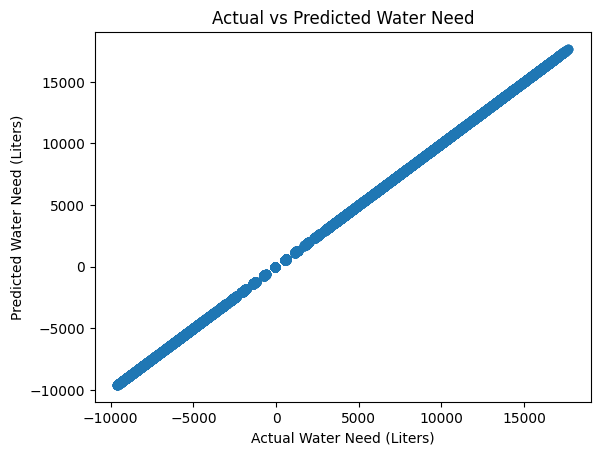

In [27]:
import matplotlib.pyplot as plt

# Plot Actual vs Predicted water needs
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Water Need (Liters)")
plt.ylabel("Predicted Water Need (Liters)")
plt.title("Actual vs Predicted Water Need")
plt.show()
